In [1]:
# Simulate parity measurement of a 6-qubit stabilizer using a bare ancilla qubit.
# The goal is to estimate the error parameters in the presence of noise
from Circuit import Circuit
from Circuit_ops import zero_state, apply, state_prob_plot
from Circuit_ops import find_fidelities, plot_fidelities, save_fidelities, read_fidelities
from Circuit_ops import find_prob, plot_prob
from Circuit_ops import int_to_bit_str, bit_str_to_int
from Error_dist import error_dist
import time
from numpy import *
import numpy as np
# import cupy as cp
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
N = 7

# Define stabilizer measurement circuit. bit_str determines first-round single-qubit gates
def stab_meas_circ(errors=[0]*6):
    circ = Circuit(N)
    circ.runs = 2 ** (N - 1)
    
    # Build circuit
    for i in range(6):
        circ.Y(i, pi/2)

    qubit_list = [0, 2, 1, 3, 5, 4]
    for i in range(len(qubit_list)):
        theta = pi/2 * (-1) ** i
#         theta = -pi/2
        circ.XX(qubit_list[i], N - 1, theta)

    for i in range(N - 1):
        circ.Y(i, -pi/2)
    
    # Generate noisy_gates
    circ.compute()
    
    # Single-qubit angles for 64 inputs
    for i in range(6):
        for j in range(2 ** 6):
            circ.noisy_gates[i][2][0][j] *= (-1) ** (int_to_bit_str(j, 6)[i])
    
    # Add noise to 2-qubit gate angles
    for i in range(6,12):
        for j in range(2 ** 6):
            circ.noisy_gates[i][2][0][j] *= 1 + errors[i-6]
    
    return circ

# Give basic statistical info about given set of fidelities
def stat_analysis(results):
    print(f"Number of data = {len(results)}")
    print(f"Average fidelity = {sum(results) / len(results)}")
    print(f"Max fidelity minus Min fidelity = {max(results) - min(results)}")
    print(f"Variance = {var(results)}")
    
# Plot probability of getting the correct ancilla qubit (essentially state fidelity)
def fid_dist(final_states, title='', plot=False, analyze=False, figsize=(10,5)):
    
    results = []
    
    # Getting the correct ancilla (7-th qubit)
    for i in range(2 ** 6):
        measured_qubits = [6]
        
        # Calculate the correct output
        sub_state = zero_state(1) * 0
        index = (sum(int_to_bit_str(i, N-1))) % 2
        sub_state[index] = 1
        
        # Compare with final output
        probs = find_prob(measured_qubits, sub_state, array(tile(final_states[i], (2,1))))
        prob = 0.5 * sum(probs)
        
        results.append(prob)
    
    # Plot fidelity for all input circuits
    if plot:
        plt.figure(figsize=figsize)
        plt.title(f"Probability of getting correct ancilla qubit VS input bit string" if title=='' else title)
        plt.plot(results)
#     if analyze:
#         stat_analysis(results)
    
    return results

def generate_results(reps):
    for i in range(reps):
        # Generate circuit
        errors = error_dist(6) * 0.2
        circ = stab_meas_circ(errors)

        # Run the circuit
        final_states = circ.compute(compile_gates=False)
        results = fid_dist(final_states, plot=True)

        
def dev(x, expected_results):
    final_states = stab_meas_circ(x).compute(compile_gates=False)
    results = fid_dist(final_states)
    dev = sum((array(results) - array(expected_results)) ** 2)
    return dev

def opt_func(x0, expected_results, maxiter=300, method='Nelder-Mead'):
    start = time.time()
    
    fun = lambda x: dev(x, expected_results)
    results = scipy.optimize.minimize(fun, x0, method=method, options={'disp': True, 'maxiter': maxiter})
    time_elapsed = time.time() - start
    print(f"Time elapsed = {time_elapsed}s")
    return results

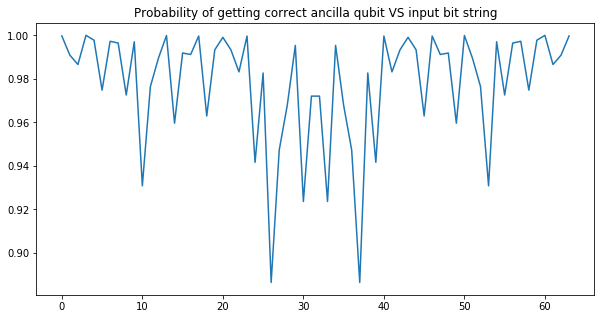

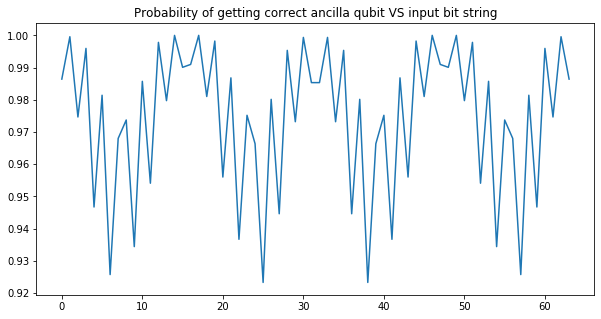

In [3]:
# Examples from random error vector
reps = 2
generate_results(reps)

In [4]:
# Assume measurements are perfect

y = array([0.32, -0.111, 0.1, -0.09, 0.22, 0.1])

final_states = stab_meas_circ(y).compute(compile_gates=False)
expected_results = fid_dist(final_states)

x0 = [0.1] * 6
_ = opt_func(x0, expected_results, method='BFGS')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 192
         Gradient evaluations: 24
Time elapsed = 3.013777017593384s


In [5]:
# Error vector
_.x

array([ 0.32000017, -0.11099984,  0.09999989, -0.08999983,  0.21999997,
        0.09999989])

In [6]:
# Assume measurement uncertainty = 5% max

meas_err = 0.1 * error_dist(64)
y = array([0.32, -0.111, 0.1, -0.09, 0.22, 0.1])

final_states = stab_meas_circ(y).compute(compile_gates=False)
expected_results = fid_dist(final_states) + meas_err

# make sure all probabilities are less than 1
for i in range(len(expected_results)):
    if expected_results[i] > 1:
        expected_results[i] = 1

x0 = [0.1] * 6
_ = opt_func(x0, expected_results, method='BFGS')

Optimization terminated successfully.
         Current function value: 0.069891
         Iterations: 19
         Function evaluations: 216
         Gradient evaluations: 27
Time elapsed = 3.309384822845459s


In [11]:
# Error vector
_.x

array([ 0.32110631, -0.11206716,  0.09932467, -0.08229948,  0.23472973,
        0.09839477])

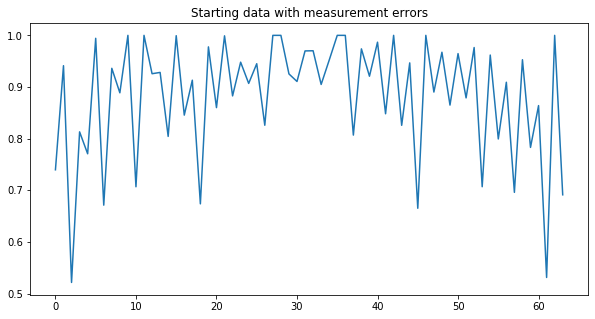

In [13]:
# Measurement data with noise

plt.figure(figsize=(10,5))
plt.title('Starting data with measurement errors')
plt.plot(expected_results)
plt.show()

In [9]:
# Percentage error
x = _.x
perc_sd = sqrt(sum(abs(x - y) ** 2) / 6) / (sum(abs(y)) / 6)

estimate_error = (x - y) / y

print(sum(abs(estimate_error)) / 6)
print(sum(abs(meas_err)) / 64)

0.03139858470313582
0.031902861213199685


In [15]:
circ = Circuit(3);
circ.Y(0, pi/2)
circ.Y(0, pi/2).XX(0,1, pi/2).X(0,-pi/2).X(1,-pi/2).Y(0, -pi/2)
final_state = circ.compute()[0]
print(final_state)

[ 5.00000000e-01+5.00000000e-01j  0.00000000e+00+0.00000000e+00j
 -2.77555756e-17-2.77555756e-17j  0.00000000e+00+0.00000000e+00j
  1.11022302e-16-5.55111512e-17j  0.00000000e+00+0.00000000e+00j
  5.00000000e-01+5.00000000e-01j  0.00000000e+00+0.00000000e+00j]
